In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
from spacetime import SpaceTime
from spacetime.simulate import Simulator
# from spacetime.models_att2 import MLPEncoder, MLPDecoder, AutoEncoder
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import train, truth_evaluation
from spacetime.utils_att import Parameters, spacetime_mutilator, graph_clipper
from spacetime.sampler import NodeData, GraphSampler

In [4]:
node_dict = {0:[0,1,2], 1:[3,4,5], 2:[6,7,8], 3:[9,10,11], 4:[12,13,14], 5:[15,16,17], 6:[18,19,20]}
# node_dict = {0:[0,1,2], 1:[3,4,5], 2:[6,7,8], 3:[9,10,11], 4:[12,13,14], 5:[15,16,17], 6:[18,19,20],
#                               7:[21,22,23], 8:[24,25,26], 9:[27,28,29], 10:[30]}
# node_dict = {0:[0,1,2,3,4], 1:[5,6,7,8,9], 2:[10,11,12,13,14], 3:[15,16,17,18,19], 4:[20,21,22,23,24], 
#                               5:[25,26,27,28,29], 6:[30]}
node_list = [j for i in node_dict.values() for j in i]
n_nodes = sum(map(len, node_dict.values()))
from spacetime.training_att import h_A, h_A_timed

sim_params = Parameters(graph_type='erdos-renyi', graph_degree=3, edge_types=2, 
                        sem_type='linear', x_dims=1, sem_noise='linear-gauss', 
                        noise_scale = 0.6, sample_size=7500, seed=42)

mod_params = Parameters(n_nodes=n_nodes, x_dims=1, h_dims=64, z_dims=1, graph_threshold=0.4)

trn_params = Parameters(batch_size=100, epochs=5)

opt_params = Parameters(constraint=lambda x: h_A_timed(x, node_dict),
                        lr=3e-3, l=1e-2, c=1.0, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=1e-8)

simulating an ordered 3-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        1.46421802, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.89764302,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.17610392, 1.52716607, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.53513131, 1.85600574, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.5462655 ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.53673559, 0.       

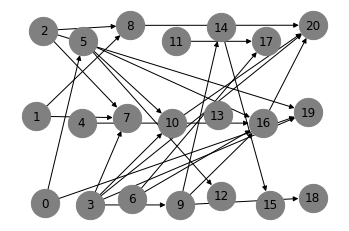

In [5]:
g = SpaceTime.from_spacetime(node_dict, simulate=True,
                             degree=sim_params.graph_degree, 
                             graph_type=sim_params.graph_type, 
                             w_range=(0.5,2.0), force_positive=True, seed=101)
g.show_adj()
g.draw_graph()

In [6]:
col_plot_dict = {0:(2,1), 1:(2,0), 2:(3,0), 3:(1,0)}
mutilate = 1
observe = 2
latent = 0

In [7]:
g.data = Simulator.sem(graph=g.graph, n=sim_params.sample_size, x_dims=sim_params.x_dims, 
                       sem_type=sim_params.sem_noise, linear_type=sim_params.sem_type, 
                       noise_scale=sim_params.noise_scale, seed=sim_params.seed)
train_loader, test_loader = g.torch_loader(g.data, trn_params.batch_size)

simulating 7500 samples from a linear-gauss sem with linear causal effects


In [8]:
####################################################################
### Ripped heavily from https://github.com/fishmoon1234/DAG-GNN
####################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

_EPS = 1e-10

class AutoEncoder(nn.Module):
    def __init__(self, mod_params):
        super(AutoEncoder, self).__init__()
        self.embedder = LinearBlock(mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double()
        self.debedder = LinearBlock(mod_params.z_dims, mod_params.h_dims, mod_params.x_dims).double()
        self.semblock = SEMBlock(mod_params.n_nodes, mod_params.z_dims).double()
        self.ennoiser = LinearBlock(mod_params.z_dims, int(mod_params.h_dims), mod_params.z_dims).double()
        self.denoiser = LinearBlock(mod_params.z_dims, int(mod_params.h_dims), mod_params.z_dims).double()
    
    def encode(self, x):
#         x = self.embedder(x)
        x, adj, Wa = self.semblock.forward(x)
        z = self.ennoiser(x)
        return z, adj, Wa
    
    def decode(self, z, adj, Wa):
        x = self.denoiser(z)
        x = self.semblock.inverse(x, adj, Wa)
#         x = self.debedder(x)
        return x
    
    def forward(self, x):
        z, adj, Wa = self.encode(x)
        out = self.decode(z, adj, Wa)
        return out, z, adj, Wa

class LinearBlock(nn.Module):
    def __init__(self, n_in, n_hid, n_out, dropout=0.0):
        super(LinearBlock, self).__init__()
        self.w_1 = nn.Linear(n_in, n_hid)
        self.w_2 = nn.Linear(n_hid, n_out)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class SEMBlock(nn.Module):
    """SEM operator module."""
    def __init__(self, num_nodes, n_out):
        super(SEMBlock, self).__init__()
        self.adj_A = nn.Parameter(Variable(torch.zeros((num_nodes, num_nodes)).double(), requires_grad=True))
        self.Wa = nn.Parameter(torch.zeros(n_out), requires_grad=True)

    def _check_nan(self):
        if torch.sum(self.adj_A != self.adj_A):
            raise ValueError('nan error \n')
            
    def op(self, adj):
        return torch.eye(adj.shape[0]).double() - (adj.transpose(0,1))
    
    def bmm(self, adj, x):
        return torch.einsum('ij,ajc->aic', adj, x)

    def forward(self, x):
        self._check_nan
        adj_A1 = torch.sinh(3*self.adj_A) # amplifying A accelerates convergence
        z = self.bmm(self.op(adj_A1), x+self.Wa)-self.Wa
        return z, adj_A1, self.Wa
    
    def inverse(self, z, adj, Wa):
        self._check_nan
        x = self.bmm(torch.inverse(self.op(adj)), z+Wa)-Wa
        return x

In [9]:
n_trials = 10

loss_log = {k:[] for k in ('elbo', 'kld', 'nll')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

shd_trials, err_trials = list(), list()
graph_trials = list()

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    #===================================
    # load modules
    #===================================
#     autoencoder = AutoEncoder(MLPEncoder(mod_params.n_nodes, mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double(),
#                               MLPDecoder(mod_params.z_dims, mod_params.x_dims, n_hid=mod_params.h_dims).double())
    autoencoder = AutoEncoder(mod_params)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*2, c_factor=10.0/2)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, train_loader, LagrangeLoss(opt=optimizerL))
            shd, err = truth_evaluation(g.show_adj(), optimizerL, mod_params.graph_threshold)
            shd_train.append(shd)
            err_train.append(err)
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l)
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL.h <= optimizerL.h_tol:
            break

    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
    print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

    shd_trials.append(shd_train)
    err_trials.append(err_train)
    graph_trials.append(optimizerL.show_adj(mod_params.graph_threshold))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
    
pass;

Iteration: 0, Best Epoch: 3/5
   ELBO: 0.0778120, KL: 10^-1.136, NLL: 10^-2.323 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 3/5
   ELBO: 0.0347150, KL: 10^-1.528, NLL: 10^-2.623 || h: 10^-0.761, c: 10^0.000, l: 0.1831924
Iteration: 2, Best Epoch: 4/5
   ELBO: 0.0213846, KL: 10^-1.699, NLL: 10^-2.855 || h: 10^-1.939, c: 10^0.000, l: 0.1946985
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.0163142, KL: 10^-1.840, NLL: 10^-2.855 || h: 10^-2.442, c: 10^0.000, l: 0.1983146
Iteration: 4, Best Epoch: 2/5
   ELBO: 0.0129656, KL: 10^-1.915, NLL: 10^-3.625 || h: 10^-2.442, c: 10^0.699, l: 0.1983146
Iteration: 5, Best Epoch: 4/5
   ELBO: 0.0112205, KL: 10^-1.977, NLL: 10^-3.985 || h: 10^-2.902, c: 10^0.699, l: 0.2045731
Iteration: 6, Best Epoch: 4/5
   ELBO: 0.0097466, KL: 10^-2.019, NLL: 10^-5.025 || h: 10^-2.902, c: 10^1.398, l: 0.2045731
Iteration: 7, Best Epoch: 4/5
   ELBO: 0.0089883, KL: 10^-2.047, NLL: 10^-5.025 || h: 10^-2.902, c: 10^2.097, l: 0.2045731
Iteration: 8, Best 

Iteration: 12, Best Epoch: 2/5
   ELBO: 0.0096956, KL: 10^-2.026, NLL: 10^-4.433 || h: 10^-4.120, c: 10^3.495, l: 0.6915718
Iteration: 13, Best Epoch: 3/5
   ELBO: 0.0092755, KL: 10^-2.050, NLL: 10^-4.584 || h: 10^-4.120, c: 10^4.194, l: 0.6915718
Iteration: 14, Best Epoch: 3/5
   ELBO: 0.0086958, KL: 10^-2.072, NLL: 10^-4.584 || h: 10^-4.120, c: 10^4.893, l: 0.6915718
Iteration: 15, Best Epoch: 2/5
   ELBO: 0.0083362, KL: 10^-2.080, NLL: 10^-4.599 || h: 10^-4.744, c: 10^4.893, l: 2.1008398
Iteration: 16, Best Epoch: 3/5
   ELBO: 0.0079502, KL: 10^-2.111, NLL: 10^-4.647 || h: 10^-5.216, c: 10^4.893, l: 2.5759746
Iteration: 17, Best Epoch: 3/5
   ELBO: 0.0076000, KL: 10^-2.133, NLL: 10^-4.647 || h: 10^-5.216, c: 10^5.592, l: 2.5759746
Iteration: 18, Best Epoch: 2/5
   ELBO: 0.0072373, KL: 10^-2.147, NLL: 10^-4.648 || h: 10^-5.216, c: 10^6.291, l: 2.5759746
Iteration: 19, Best Epoch: 1/5
   ELBO: 0.0069955, KL: 10^-2.169, NLL: 10^-4.648 || h: 10^-6.175, c: 10^6.291, l: 3.8827760
Iteratio

Iteration: 19, Best Epoch: 4/5
   ELBO: 0.0069600, KL: 10^-2.166, NLL: 10^-4.763 || h: 10^-6.067, c: 10^6.291, l: 5.0510140
Iteration: 20, Best Epoch: 3/5
   ELBO: 0.0066625, KL: 10^-2.184, NLL: 10^-4.795 || h: 10^-6.463, c: 10^6.291, l: 5.7229413
Iteration: 21, Best Epoch: 3/5
   ELBO: 0.0063717, KL: 10^-2.199, NLL: 10^-4.795 || h: 10^-6.463, c: 10^6.990, l: 5.7229413
Iteration: 22, Best Epoch: 4/5
   ELBO: 0.0061133, KL: 10^-2.218, NLL: 10^-4.931 || h: 10^-6.463, c: 10^7.689, l: 5.7229413
Iteration: 23, Best Epoch: 2/5
   ELBO: 0.0059576, KL: 10^-2.231, NLL: 10^-4.931 || h: 10^-6.990, c: 10^7.689, l: 10.7235768
Iteration: 24, Best Epoch: 3/5
   ELBO: 0.0057158, KL: 10^-2.249, NLL: 10^-4.931 || h: 10^-7.405, c: 10^7.689, l: 12.6449967
Iteration: 25, Best Epoch: 3/5
   ELBO: 0.0054794, KL: 10^-2.267, NLL: 10^-5.005 || h: 10^-7.405, c: 10^8.388, l: 12.6449967
Iteration: 26, Best Epoch: 4/5
   ELBO: 0.0052672, KL: 10^-2.282, NLL: 10^-5.005 || h: 10^-7.405, c: 10^9.087, l: 12.6449967
Iter

Iteration: 27, Best Epoch: 3/5
   ELBO: 0.0045685, KL: 10^-2.349, NLL: 10^-4.831 || h: 10^-7.639, c: 10^9.087, l: 14.6751698
Iteration: 28, Best Epoch: 4/5
   ELBO: 0.0043737, KL: 10^-2.363, NLL: 10^-4.831 || h: 10^-7.639, c: 10^9.786, l: 14.6751698

Trial 6 finished in 68.73152732849121 seconds
Best ELBO Stats: shd 0 err 0.8905997896637357

Iteration: 0, Best Epoch: 4/5
   ELBO: 0.0643584, KL: 10^-1.241, NLL: 10^-2.159 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 3/5
   ELBO: 0.0389431, KL: 10^-1.523, NLL: 10^-2.229 || h: 10^-1.222, c: 10^0.000, l: 0.0700067
Iteration: 2, Best Epoch: 3/5
   ELBO: 0.0231607, KL: 10^-1.650, NLL: 10^-3.455 || h: 10^-1.222, c: 10^0.699, l: 0.0700067
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.0200951, KL: 10^-1.737, NLL: 10^-3.455 || h: 10^-2.036, c: 10^0.699, l: 0.1160346
Iteration: 4, Best Epoch: 3/5
   ELBO: 0.0168911, KL: 10^-1.804, NLL: 10^-4.025 || h: 10^-2.036, c: 10^1.398, l: 0.1160346
Iteration: 5, Best Epoch: 4/5
   ELBO: 0.014

Iteration: 12, Best Epoch: 0/5
   ELBO: 0.0090309, KL: 10^-2.067, NLL: 10^-5.019 || h: 10^-3.696, c: 10^3.495, l: 0.4031376
Iteration: 13, Best Epoch: 1/5
   ELBO: 0.0084692, KL: 10^-2.087, NLL: 10^-5.019 || h: 10^-3.696, c: 10^4.194, l: 0.4031376
Iteration: 14, Best Epoch: 4/5
   ELBO: 0.0081827, KL: 10^-2.107, NLL: 10^-5.019 || h: 10^-4.577, c: 10^4.194, l: 0.8171879
Iteration: 15, Best Epoch: 0/5
   ELBO: 0.0077436, KL: 10^-2.127, NLL: 10^-5.019 || h: 10^-4.577, c: 10^4.893, l: 0.8171879
Iteration: 16, Best Epoch: 3/5
   ELBO: 0.0076133, KL: 10^-2.145, NLL: 10^-5.019 || h: 10^-5.085, c: 10^4.893, l: 1.4599344
Iteration: 17, Best Epoch: 3/5
   ELBO: 0.0069579, KL: 10^-2.166, NLL: 10^-5.019 || h: 10^-5.085, c: 10^5.592, l: 1.4599344
Iteration: 18, Best Epoch: 4/5
   ELBO: 0.0065695, KL: 10^-2.183, NLL: 10^-5.156 || h: 10^-5.085, c: 10^6.291, l: 1.4599344
Iteration: 19, Best Epoch: 4/5
   ELBO: 0.0064263, KL: 10^-2.194, NLL: 10^-5.156 || h: 10^-6.010, c: 10^6.291, l: 3.3686908
Iteratio

0.8000 +- 2.0881
1.0858 +- 0.4625


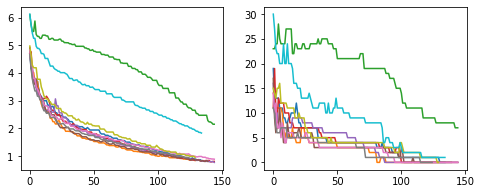

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (8,3))

for trial in range(n_trials):
    axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
    axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
    
shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
err_finals = [err_trials[i][-1] for i in range(n_trials)]
print("{:0.4f} +- {:0.4f}".format(np.mean(shd_finals), np.std(shd_finals)))
print("{:0.4f} +- {:0.4f}".format(np.mean(err_finals), np.std(err_finals)))
pass;

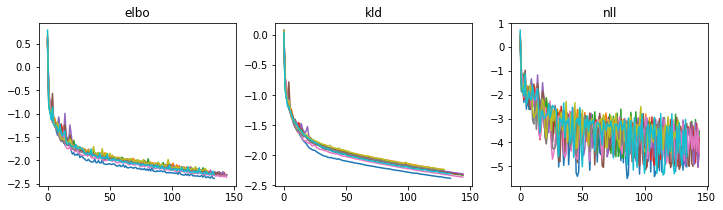

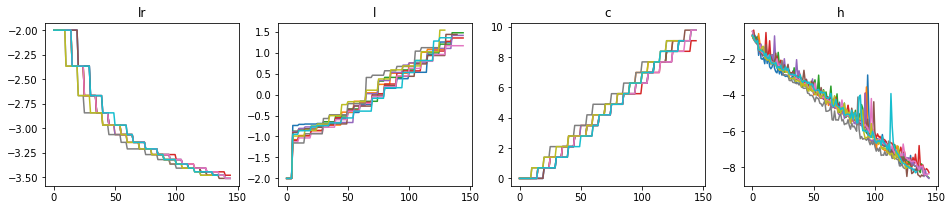

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))

for i, (k,v) in enumerate(loss_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (16,3))

for i, (k,v) in enumerate(param_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
pass;

In [12]:
# fig, axs = plt.subplots(1, 4, figsize = (16,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(lr_trials[trial])), np.log10(lr_trials[trial]))
#     axs[1].plot(range(len(cA_trials[trial])), np.log10(cA_trials[trial]))
#     axs[2].plot(range(len(hA_trials[trial])), np.log10(hA_trials[trial]))
#     axs[3].plot(range(len(lam_trials[trial])), np.log10(lam_trials[trial]))
# pass;

In [13]:
# fig, axs = plt.subplots(1, 5, figsize = (15,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
#     axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
#     axs[2].plot(range(len(kl_trials[trial])), np.log10(kl_trials[trial]))
#     axs[3].plot(range(len(nll_trials[trial])), np.log10(nll_trials[trial]))
#     axs[4].plot(range(len(elbo_trials[trial])), np.log10(elbo_trials[trial]))
# pass;

# shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
# err_finals = [err_trials[i][-1] for i in range(n_trials)]
# print("%s +- %s"%(np.around(np.mean(shd_finals), 3), np.around(np.std(shd_finals), 3)))
# print("%s +- %s"%(np.around(np.mean(err_finals), 3), np.around(np.std(err_finals), 3)))

In [14]:
blah

NameError: name 'blah' is not defined

## SEM Evaluation

In [ ]:
g_learned = SpaceTime.from_adjacency(best_ELBO_graph)
g_learned.draw_graph()

In [ ]:
encoder.eval()
decoder.eval()

data = next(iter(test_loader))[0].double()
_, noise, _, _, _, _, Wa_train = encoder(data)
_, preds = decoder(noise, g_learned.torch_graph(), Wa_train)

In [ ]:
Wa_train

In [ ]:
X_train = NodeData(g.data, bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [ ]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

In [ ]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [ ]:
_, preds_resampled_cdf = decoder(g_learned.torch_data(Z_resampled_cdf.data()), g_learned.torch_graph(), Wa_train)
_, preds_resampled_pdf = decoder(g_learned.torch_data(Z_resampled_pdf.data()), g_learned.torch_graph(), Wa_train)
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=15)
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=15)

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pX_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

## Graph Mutilation Tests

In [ ]:
g_mutil = spacetime_mutilator(g, mutilate=[mutilate])
g_mutil.data = Simulator.sem(graph=g_mutil.graph, n=10000, x_dims=args.x_dims, 
                             sem_type=args.graph_sem_type, linear_type=args.graph_linear_type, 
                             noise_scale=args.noise_scale, seed=args.seed)

In [ ]:
g_learned.draw_graph()

g_learned_mutil = spacetime_mutilator(g_learned, mutilate=[mutilate])
g_learned_mutil.draw_graph()

In [ ]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [ ]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

In [ ]:
_, preds_resampled_mutil_cdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_cdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
_, preds_resampled_mutil_pdf = decoder(g_learned_mutil.torch_data(Z_resampled_mutil_pdf.data()), 
                                       g_learned_mutil.torch_graph(), Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

In [ ]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [ ]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;

In [ ]:
# shd_trials

#### noise = 0.1
# [5, 5, 3, 3, 5, 3, 7, 4, 5, 6, 6, 3, 4, 3, 5, 3, 4, 6, 4, 4]
# 4.4 +- 1.2
# [5, 3, 3, 2, 5, 5, 5, 7, 4, 2, 3, 2, 4, 4, 5, 4, 3, 4, 5, 4]
# 3.95 +- 1.24

#### noise = 0.3
# [1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3]
# 2.05 +- 0.589

#### noise = 0.5
# [1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0]
# 1.2 +- 0.60

#### noise = 0.7
# [0, 1, 0, 1, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]
# 0.65 +- 0.726

In [ ]:
# shd_trials
# np.mean(shd_trials)
# np.std(shd_trials)

####### node_dict = {0:[0,1], 1:[2,3,4], 2:[5,6]}
#### noise = 0.05
### h_A experiments
# [9, 9, 11, 9, 9, 10, 9, 6, 9, 7]
# 8.8 +- 1.32664991614216
### h_A_ordered experiments
# [2, 6, 7, 5, 5, 4, 6, 7, 6, 6]
# 5.4 +- 1.42828568570857

#### noise = 0.1
### h_A experiments
# [7, 8, 7, 9, 8, 8, 4, 9, 5, 8]
# 7.3 +- 1.5524174696260025
### h_A_ordered experiments
# [1, 1, 5, 4, 4, 4, 4, 5, 3, 1]
# 3.2 +- 1.5362291495737217